In [1]:
import numpy as np
from itertools import product
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import Image
from mpire import WorkerPool
from matplotlib import style

In [2]:
class Schelling:

    def __init__(self, size:int, N:int, jr:float, jb:float, offset:int):
        """
            size - number of locations in the grid,
            N - total number of agents, Nr = Nb = N/2
            jr - similar neighbor index for red agents,
            jb - similar neighbor index for blue agents,
            offset - neighborhood radius, number of neighbors will be (2*offset + 1)**2 - 1
        """

        self.grid = None
        self.Grids = None
        self.size = size
        self.L = int(np.sqrt(size))
        self.N = N
        self.jr = jr
        self.jb = jb
        self.offset = offset
        self.TS = None
        self.SNI = None

    def initGrid(self):

        grid = np.zeros(self.size, dtype=int)
        indices = list(range(self.size))
        populated = np.random.choice(indices, self.N, replace=False)
        red = populated[:int(self.N/2)]
        blue = populated[int(self.N/2):]
        grid[red] = 1
        grid[blue] = 2
        self.grid = grid.reshape((self.L, self.L))

    def getNeighbors(self, row, col):
        
        L = self.L

        row_offsets = list(range(-self.offset, self.offset+1))
        col_offsets = row_offsets
        neighbors = {((row+r)%L, (col+c)%L) for r, c in product(row_offsets, col_offsets)}
        neighbors.discard((row, col))

        return list(neighbors)
    
    def getSNI(self, row, col):
        
        color = self.grid[row, col]
        neighbors = self.getNeighbors(row, col)
        all = [n for n in neighbors if self.grid[n[0], n[1]] != 0]
        similar = [n for n in all if self.grid[n[0], n[1]] == color]
        
        return len(similar) / len(all) if len(all) != 0 else 0
    
    def simulate(self):

        self.initGrid()
        
        agents = np.where(self.grid != 0)
        occupied = list(zip(*agents))
        free = list(zip(*np.where(self.grid == 0)))
        jts = {1: self.jr, 2: self.jb}
        agents_cols = self.grid[agents[0], agents[1]]
        agents_jts = [jts[col] for col in agents_cols]
        agents_happy = [self.getSNI(agents[0][i], agents[1][i]) >= agents_jts[i] \
                      for i in range(len(agents_jts))]

        self.Grids = np.copy(self.grid)
        L = self.L
        ts = 0

        while True:
            grid = self.grid

            for _ in range(self.N):

                agent_ind = np.random.randint(len(occupied))
                agent = occupied[agent_ind]
                color = grid[agent[0], agent[1]]
                jt = jts[color]
                agent_sim = self.getSNI(agent[0], agent[1])
                agents_happy[agent_ind] = agent_sim >= jt

                if agent_sim < jt:

                    new_ind = np.random.randint(len(free))
                    new = free[new_ind]
                    grid[agent[0], agent[1]] = 0
                    grid[new[0], new[1]] = color
                    occupied[agent_ind] = new
                    free[new_ind] = agent

            self.Grids = np.vstack((self.Grids, grid))
            self.grid = grid
            ts += 1

            if np.all(agents_happy) == True:
                break   

        self.Grids = [self.Grids[i*L:(i+1)*L, :] for i in range(ts)]  
        self.TS = ts
        self.SNI = np.mean([self.getSNI(agent[0], agent[1]) for agent in occupied])

    def animate(self, filename):

        self.simulate()
        frames = self.Grids
        colors = ['white', 'darkred', 'darkblue']
        custom_cmap = ListedColormap(colors)

        fig, ax = plt.subplots()

        def _initAnim():
            ax.clear()
            im = ax.imshow(frames[0], cmap=custom_cmap)
            return [im]

        def _updateAnim(frame):
            ax.clear()
            im = ax.imshow(frames[frame], cmap=custom_cmap)
            return [im]

        ani = FuncAnimation(fig, _updateAnim, frames=len(frames), init_func=_initAnim, blit=True, interval=100)
        ani.save(filename, writer='pillow')


### Animations

In [3]:
plt.rcParams['figure.dpi'] = 150

In [4]:
%%capture
ss = Schelling(10**4, 8000, 1/2, 1/2, 1)
ss.animate('schelling1.gif')

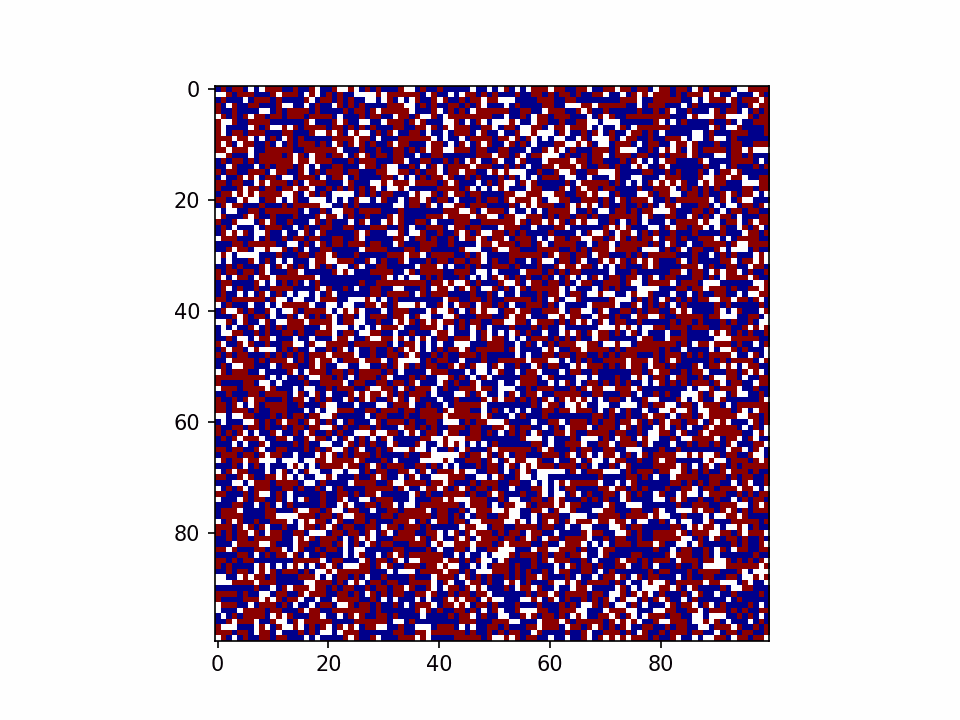

In [5]:
Image(filename='schelling1.gif')

In [6]:
%%capture
ss2 = Schelling(10**4, 500, 1/2, 1/2, 1)
ss2.animate('schelling2.gif')

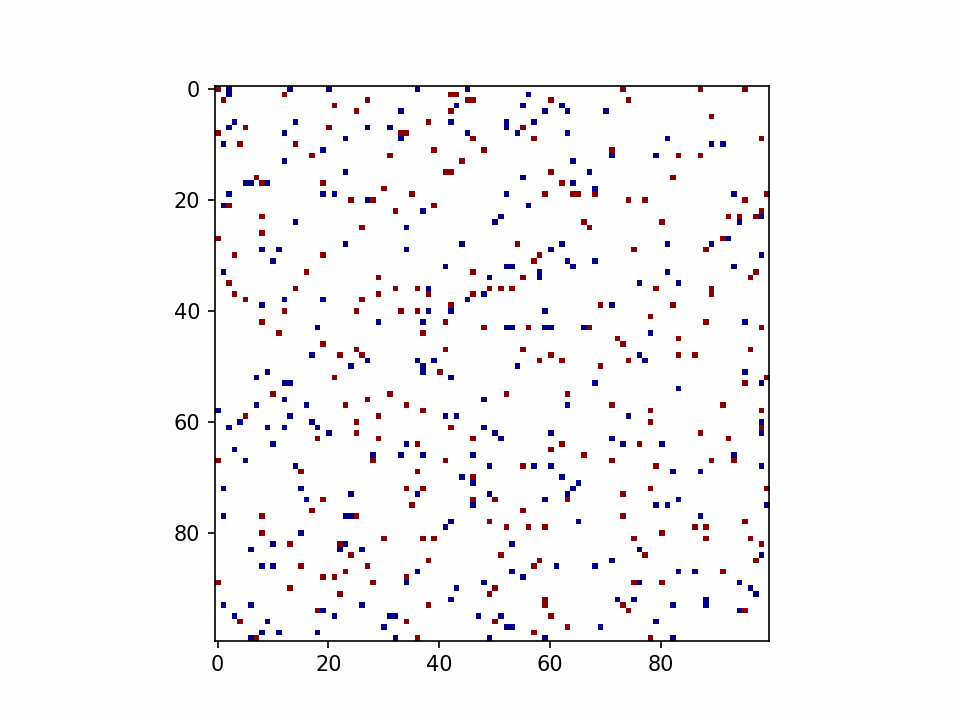

In [7]:
Image(filename='schelling2.gif')

In [ ]:
%%capture
ss3 = Schelling(10**4, 8000, 3/8, 5/8, 1)
ss3.animate('schelling3.gif')

### Simulations

Number of iterations as function of grid size

In [7]:
def avgTimeStep(n):
    iters = np.zeros(100)

    for j in range(100):
        S = Schelling(10**4, n, 0.5, 0.5, 1)
        S.simulate()
        iters[j] = S.TS

    return np.mean(iters)

In [8]:
ns = np.arange(500, 8001, 500)
results = np.zeros(len(ns))

for i, n in enumerate(ns):
    results[i] = avgTimeStep(n)

In [8]:
plt.rcParams['figure.figsize'] = (10, 6)
style.use('seaborn-v0_8')

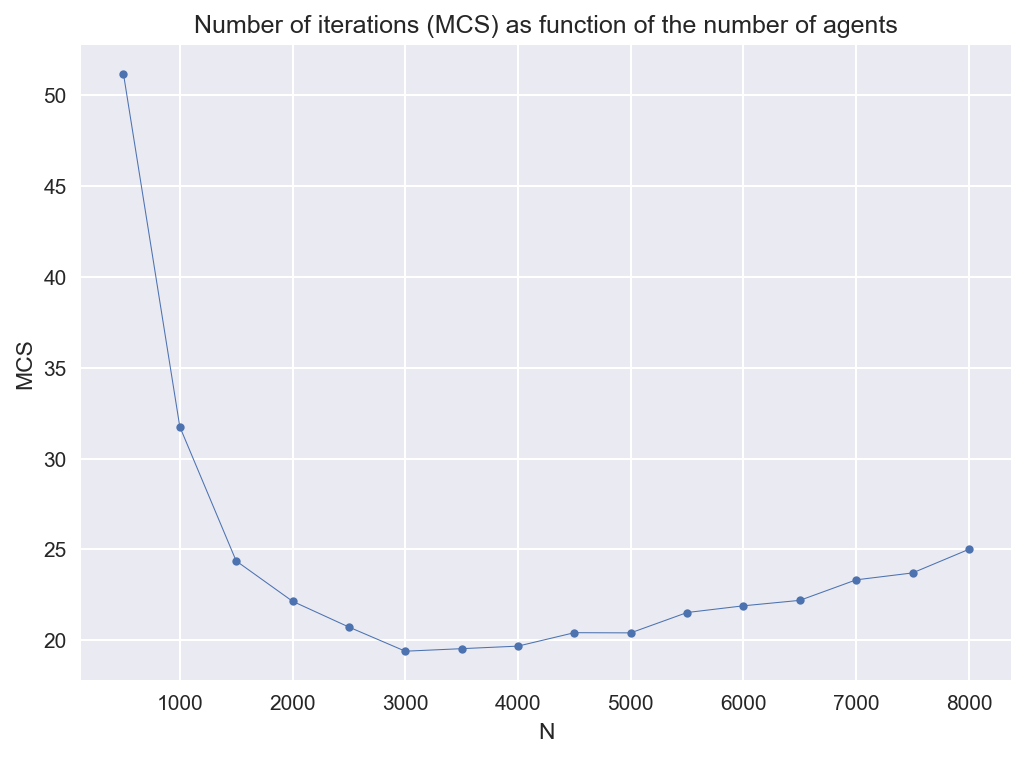

In [10]:
plt.plot(ns, results, marker='o', linewidth=0.5, markersize=4)
plt.title('Number of iterations (MCS) as function of the number of agents')
plt.xlabel('N')
plt.ylabel('MCS')
plt.savefig('MCS.png')

Segregation index

In [11]:
def avgSNIjt(jt):
    SNIs = np.zeros(100)

    for i in range(100):
        S = Schelling(10**4, 4000, jt, jt, 1)
        S.simulate()
        SNIs[i] = S.SNI

    return np.mean(SNIs)

In [9]:
def avgSNImt(offset):
    SNIs = np.zeros(100)

    for i in range(100):
        S = Schelling(10**4, 4000, 0.5, 0.5, offset)
        S.simulate()
        SNIs[i] = S.SNI

    return np.mean(SNIs)

In [ ]:
jts = np.arange(0.1, 1, 0.1)
jt_results = np.zeros(len(jts))

for i, jt in enumerate(jts):
    jt_results[i] = avgSNIjt(jt)
    print(jt)

In [ ]:
mts = np.arange(1, 6, 1)
mt_results = np.zeros(len(mts))

for i, mt in enumerate(mts):
    mt_results[i] = avgSNImt(mt)

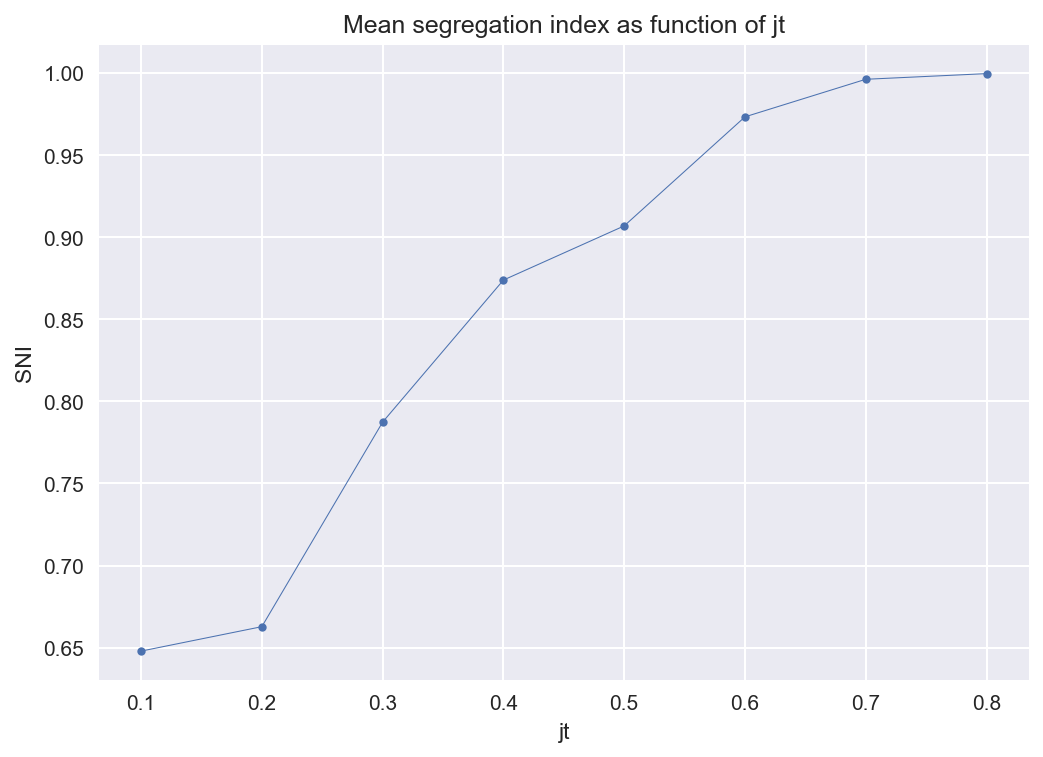

In [14]:
plt.plot(jts[:-1], jt_results[:-1], marker='o', linewidth=0.5, markersize=4)
plt.title('Mean segregation index as function of jt')
plt.xlabel('jt')
plt.ylabel('SNI')
plt.savefig('SNIjt.png')

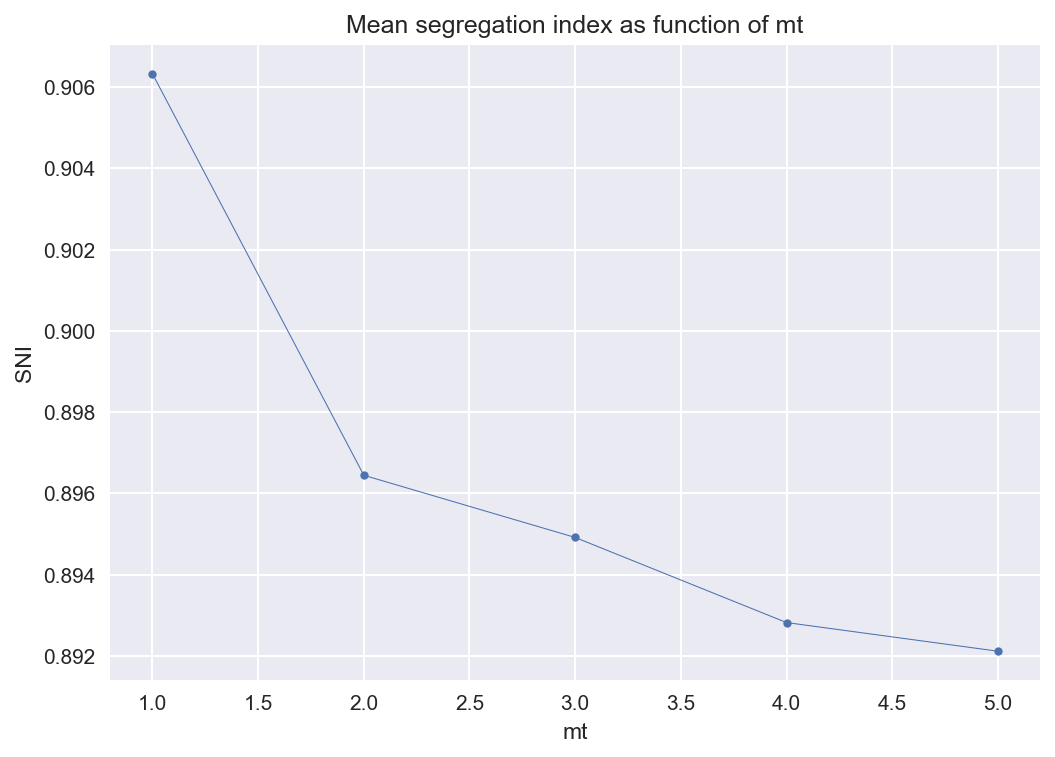

In [11]:
plt.plot(mts, mt_results, marker='o', linewidth=0.5, markersize=4)
plt.title('Mean segregation index as function of mt')
plt.xlabel('mt')
plt.ylabel('SNI')
plt.savefig('SNImt.png')